# **Project Speech Recognition System**

 **Table of Contents**

1. Introduction
2. Project Overview
3. Tools and Libraries
4. Data Collection and Preprocessing
5. Model Architecture
6. Training the Model
7. Evaluation and Testing
8. Deployment
9. Future Work
10. References

>

# **Introduction**

Speech recognition is the process of converting spoken language into text. This project aims to create a robust speech recognition system using advanced neural network architectures like Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, or Transformers.

>

# **Project Overview**

The goal of this project is to develop a speech recognition system that can accurately transcribe spoken language into written text. The system will be trained on audio data and will leverage deep learning techniques to achieve high accuracy.



# **Libraries**

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import librosa.display
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,LSTM,Dropout,Embedding,GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
plt.style.use('ggplot')
%matplotlib inline

>

# **Data Collection and Preprocessing**

>

In [ ]:
!wget http://www.openslr.org/resources/12/train-clean-100.tar.gz
import tarfile
tar = tarfile.open('/content/train-clean-100.tar.gz')
tar.extractall('./Data')
tar.close()

--2024-08-09 08:45:00--  http://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://openslr.elda.org/resources/12/train-clean-100.tar.gz [following]
--2024-08-09 08:45:01--  http://openslr.elda.org/resources/12/train-clean-100.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  31.6MB/s    in 3m 14s  

2024-08-09 08:48:15 (31.4 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]



# **Data Visulaization**

>

In [ ]:
# Display Audio
from IPython import display
display.Audio('/content/Data/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac')

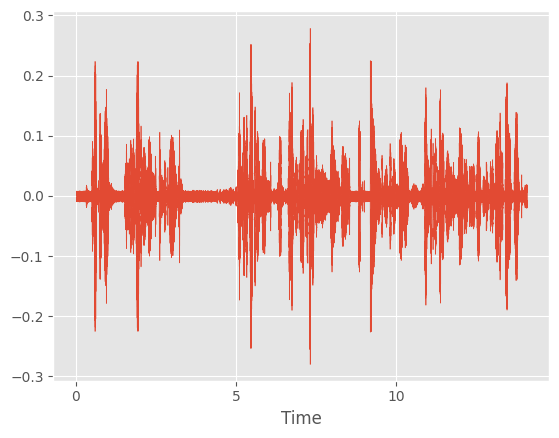

In [ ]:
# Plot Wave to show shound
y,sr =  librosa.load('/content/Data/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac',sr=16000)
librosa.display.waveshow(y,sr=sr)
plt.show()

# **MAKE DATA IN DATAFRAME SHAPE**

In [ ]:

dataset_path = "/content/Data/LibriSpeech"

audio_paths = []
transcriptions = []

# Traverse the directory structure
for root, dirs, files in os.walk(dataset_path):
    # Find the transcription file in the current directory
    transcription_file = None
    for file in files:
        if file.endswith(".txt"):
            transcription_file = os.path.join(root, file)
            break

    if transcription_file:
        # Load all transcriptions into a dictionary
        transcriptions_dict = {}
        with open(transcription_file, 'r') as f:
            for line in f:
                parts = line.strip().split(" ", 1)
                transcriptions_dict[parts[0]] = parts[1]

        # Process each audio file in the directory
        for file in files:
            if file.endswith(".flac"):
                # Get the file ID (without the extension)
                file_id = file[:-5]

                # Get the corresponding transcription
                transcription = transcriptions_dict.get(file_id, "[No transcription found]")

                # Store the data
                audio_paths.append(os.path.join(root, file))
                transcriptions.append(transcription)

# Create a DataFrame
df = pd.DataFrame({
    'audio_path': audio_paths,
    'transcription': transcriptions
})

# Display the first few rows of the DataFrame
df.head()

,audio_path,transcription
0,/content/Data/LibriSpeech/train-clean-100/7402...,BECAUSE IT IS FROM AN ORTHODOX POINT OF VIEW G...
1,/content/Data/LibriSpeech/train-clean-100/7402...,RATHER WHEN HE IS PRESENTING A QUEER FIZZING M...
2,/content/Data/LibriSpeech/train-clean-100/7402...,A FEW ONLY OF THESE LATTER TYPES ARE GIVEN US ...
3,/content/Data/LibriSpeech/train-clean-100/7402...,HE OBSERVES IN ONE OF THE MANY PASSAGES IN WHI...
4,/content/Data/LibriSpeech/train-clean-100/7402...,FOR INSTANCE WHAT MANY CRITICS HAVE FAILED TO ...


# **CHECK VOICE AND LABEL IS CORRECT**

BECAUSE IT IS FROM AN ORTHODOX POINT OF VIEW GENIALITY IN THE WRONG PLACE IT IS LIKE A GRIN IN CHURCH A LAUGH AT A MARRIAGE SERVICE




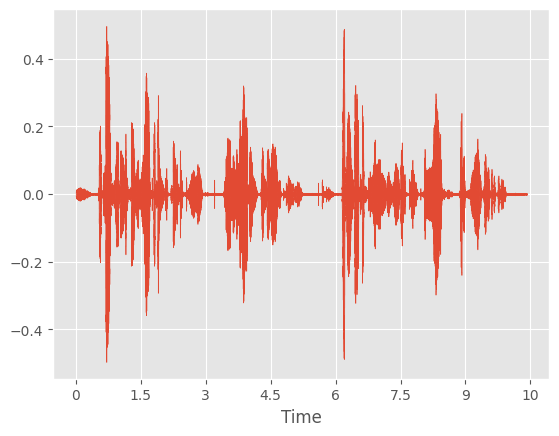

In [ ]:
print(df['transcription'][0])
print('\n')
y,sr = librosa.load(df['audio_path'][0],sr=16000)
librosa.display.waveshow(y,sr=sr)

plt.show()
print('\n \n')
display.Audio(df['audio_path'][0])


>

# **Tokenizer Transcription**


1. Tokenization transforms raw text into a structured format that deep learning models can process efficiently, helping in managing vocabulary, handling text length, and ultimately improving model performance

# **Pad Sequences**
1. Length of all word must be same, Thats help to train Neural Network (ANN)





>

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['transcription'])
sequences = tokenizer.texts_to_sequences(df['transcription'])

## ----------------------


max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='pre')

In [ ]:
y = np.array(padded_sequences)
y.shape

(28539, 75)

In [ ]:
from concurrent.futures import ThreadPoolExecutor

def Extract_Feature(path):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    return mfcc.T

# Function to process a list of audio paths
def process_audio_paths(audio_paths):
    with ThreadPoolExecutor(max_workers=27) as executor:  # Set max_workers to 10
        results = list(executor.map(Extract_Feature, audio_paths))
    return results

# Assuming df['audio_path'] is a list of audio file paths
extract_audio = process_audio_paths(df['audio_path'].tolist())

# If you want to add the results back to your DataFrame
df['features'] = extract_audio

In [ ]:
length = 500
extract_audio = pad_sequences(extract_audio,maxlen=length,padding='pre')
extranced_audio = np.array(extract_audio)
X = extranced_audio
X.shape

NameError: name 'pad_sequences' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(22831, 500, 20)
(22831, 75)


In [ ]:
model = Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(length,20)))
model.add(Dropout(0.2))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1],activation='softmax'))
model.summary()


NameError: name 'Sequential' is not defined

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

In [ ]:
EarlyStopping = EarlyStopping(monitor='val_loss',patience=15,verbose=1)
log_dir = 'logs/fit'
Tensorboard = TensorBoard(log_dir=log_dir,histogram_freq=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32,validation_data=(X_test,y_test), callbacks=[EarlyStopping, Tensorboard])


Epoch 1/100
714/714 ━━━━━━━━━━━━━━━━━━━━ 1283s 2s/step - accuracy: 0.0473 - loss: 9657284.0000 - val_accuracy: 0.0927 - val_loss: 82236776.0000
Epoch 2/100
714/714 ━━━━━━━━━━━━━━━━━━━━ 1255s 2s/step - accuracy: 0.0940 - loss: 134203336.0000 - val_accuracy: 0.0927 - val_loss: 298844800.0000
Epoch 3/100
689/714 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.0896 - loss: 383395328.0000